<a href="https://colab.research.google.com/github/scaairesearch/da_demo/blob/main/da_mnist_demo_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation Demonstration
- get data
- create model architecture
- train baseline and non-da
- save models
- infer model
- grad cam on correctly classified and misclassified images
- mis classified images

# Objective / Target
**Objective / Target**
* Increase accuracy by increasing capacity
* Play with LR

**Results**

* Parameters: 7,900
* Best Train Accuracy: 98.91
* Best Test Accuracy: 99.31

**Analysis**

* Not Able to hit the accuracy mark
* Overfitting (train - test accuracy) < 0 is largely containted, model underfits (Target not achieved)
* LR has played its role to move up the accuracy
* Number of params < 8K
* Adding params near output helped much, so did removing input

**Next Steps**

* Play with large LR


# Importing Libraries

In [28]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates
import torch.utils.data as data # for MNISTM dataset
from PIL import Image
import os

## Seed and Cuda

In [16]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED)
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : False


### Constants

In [30]:
img_size = 28 # for mnist
cpu_batch_size = 64
cuda_batch_size = 128
EPOCHS = 2 # 15 if cuda else 2

source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
model_root = 'models'
# cuda = True
# cudnn.benchmark = True
lr = 1e-3
# batch_size = 128
# image_size = 28
# n_epoch = 100

# Source Data

## Data Transforms

In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train / Test Split

In [19]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data',
                      train=False,
                      download=True,
                      transform=test_transforms)

## Data Loader

In [20]:
dataloader_args = dict(shuffle=True, batch_size=cuda_batch_size, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

## Checking Dataloader

In [21]:
# next(iter(train_loader))

torch.Size([64, 1, 28, 28]) torch.Size([64])
Label = 8


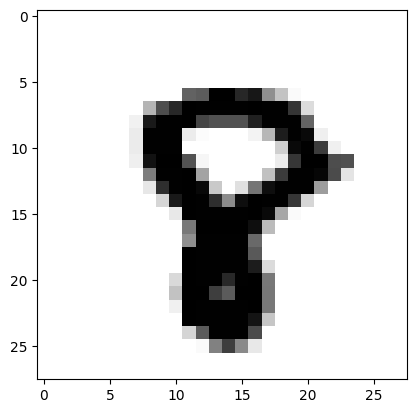

In [22]:
images, labels  = next(iter(train_loader))
print(images.shape, labels.shape)
# printing random image and seeing
random_idx = random.randint(0,len(images))
plt.imshow(images[random_idx].numpy().squeeze(), cmap='gray_r')
print(f'Label = {labels[random_idx].item()}' )

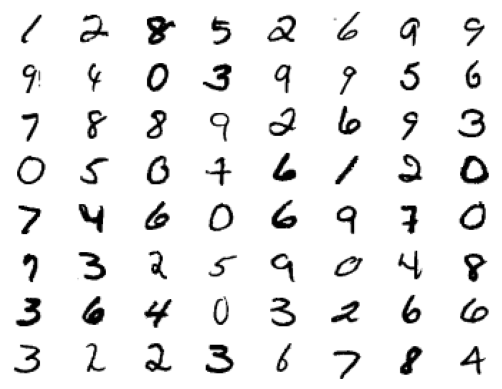

In [23]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Target Data

## Data Transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize(img_size),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

## Dataset Class

In [ ]:
class MNISTM(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

## Dataset

In [29]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/gdrive


In [ ]:
dataset_target = datasets.MNISTM(data_root = './data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data',
                      train=False,
                      download=True,
                      transform=test_transforms)

## Dataloader

In [ ]:
dataloader_target = data.

# Model

In [24]:
# class Network(nn.Module):
#   def __init__(self):
#     super(Network,self).__init__() # extending super class method

#     drop_out_value = 0.1

#     # Input Block
#     self.convblock1 = nn.Sequential(
#         nn.Conv2d(3,16,3 , bias= False ), # In- 3x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 2
#     self.convblock2 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 3
#     self.convblock3 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Transition Block 1 (this also includes a conv block)
#     self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2


#     # Conv Block 4
#     self.convblock4 = nn.Sequential(
#         nn.Conv2d(16,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(16),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Conv Block 5
#     self.convblock5 = nn.Sequential(
#         nn.Conv2d(16,32,3, bias= False ), # In- 16x9x9, Out- 32x7x7, RF- 16x16, Jump_in -2, Jump_out -2
#         nn.ReLU(),
#         nn.BatchNorm2d(32),# affine=False),
#         nn.Dropout(drop_out_value)
#     )

#     # Output Block
#     self.convblock6 = nn.Sequential(
#         nn.Conv2d(32,64,1, bias= False ), # In- 32x7x7, Out- 64x7x7, RF- 16x16, Jump_in -2, Jump_out -2
#     )

#     self.gap = nn.AvgPool2d(7) # In- 64x7x7, Out- 64x1x1, RF- 16x16, Jump_in -2, Jump_out -2

#     self.feature = nn.Sequential(self.convblock1,
#                                  self.convblock2,
#                                  self.convblock3,
#                                  self.pool1,
#                                  self.convblock4,
#                                  self.convblock5,
#                                  self.convblock6,
#                                  self.gap
#                                 )


#   def forward(self,x):
#     x = self.feature(x)

#     # x = self.convblock1(x)
#     # x = self.convblock2(x)
#     # x = self.convblock3(x)

#     # x = self.pool1(x)
#     # # x = self.convblock4(x)
#     # x = self.convblock5(x)
#     # x = self.convblock6(x)

#     # x = self.convblock7(x)

#     # x = self.gap(x)

#     # Flattening
#     x = x.view(-1,64)
#     return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()  # Initialize the parent class

        drop_out_value = 0.1

        # Define the feature extraction module with all layers
        self.feature = nn.Sequential(
            # Input Block
            nn.Conv2d(3, 16, 3, bias=False),  # In: 3x28x28, Out: 16x26x26, RF: 3x3, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 2
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x26x26, Out: 16x24x24, RF: 5x5, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 3
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x24x24, Out: 16x22x22, RF: 7x7, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Transition Block 1
            nn.MaxPool2d(kernel_size=2, stride=2),  # In: 16x22x22, Out: 16x11x11, RF: 8x8, Stride: 2

            # Conv Block 4
            nn.Conv2d(16, 16, 3, bias=False),  # In: 16x11x11, Out: 16x9x9, RF: 12x12, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop_out_value),

            # Conv Block 5
            nn.Conv2d(16, 32, 3, bias=False),  # In: 16x9x9, Out: 32x7x7, RF: 16x16, Stride: 1
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(drop_out_value),

            # Output Block
            nn.Conv2d(32, 64, 1, bias=False),  # In: 32x7x7, Out: 64x7x7, RF: 16x16, Stride: 1

            # Global Average Pooling
            nn.AvgPool2d(7)  # In: 64x7x7, Out: 64x1x1, RF: 16x16, Stride: 7
        )

    def forward(self, x):
      if x.data.shape[1] == 1:
        x = x.expand(x.data.shape[0], 3, img_size, img_size)
      x = self.feature(x)
      x = x.view(x.size(0), -1)  # Flatten the output for fully connected layer if needed
      return x

# Create an instance of the network and print it
model = Network()
print(model)


Network(
  (feature): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (14): ReLU()
    (15): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.1, inplace=False)
    (17): Conv2d

## Model Params

In [26]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(3, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             432
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-

# Training and Testing

## Training

In [27]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_accuracy.append(100*correct/processed)


## Test

In [14]:
# Test Function
test_losses = [] # to capture test losses
test_accuracy = [] # to capture test accuracy

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  avg_epoch_test_loss =[]
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches
    avg_epoch_test_loss.append(test_loss)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))
  return float("{:.4f}".format(np.average(avg_epoch_test_loss)))


## Execution

In [15]:

## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)


In [18]:
model =  Network().to(device)
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=0.4, momentum=0.9)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 1, threshold =  0.0002, verbose = True)



for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1 , "Current LR : ", optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    curr_lr = optimizer.param_groups[0]['lr']
    # print(f'current learning rate :', curr_lr)
    val_loss = test(model, device, test_loader)
    # print(f'current learning rate :{curr_lr} and val_loss is {val_loss}')
    scheduler.step(val_loss)




EPOCH: 1 Current LR :  0.4


Loss=nan Batch_id=468 Accuracy=10.37%: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: nan, Accuracy: 980/10000 (9.80%)

EPOCH: 2 Current LR :  0.4


Loss=nan Batch_id=468 Accuracy=9.87%: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]



Test set: Average loss: nan, Accuracy: 980/10000 (9.80%)



Text(0.5, 1.0, 'Test Accuracy')

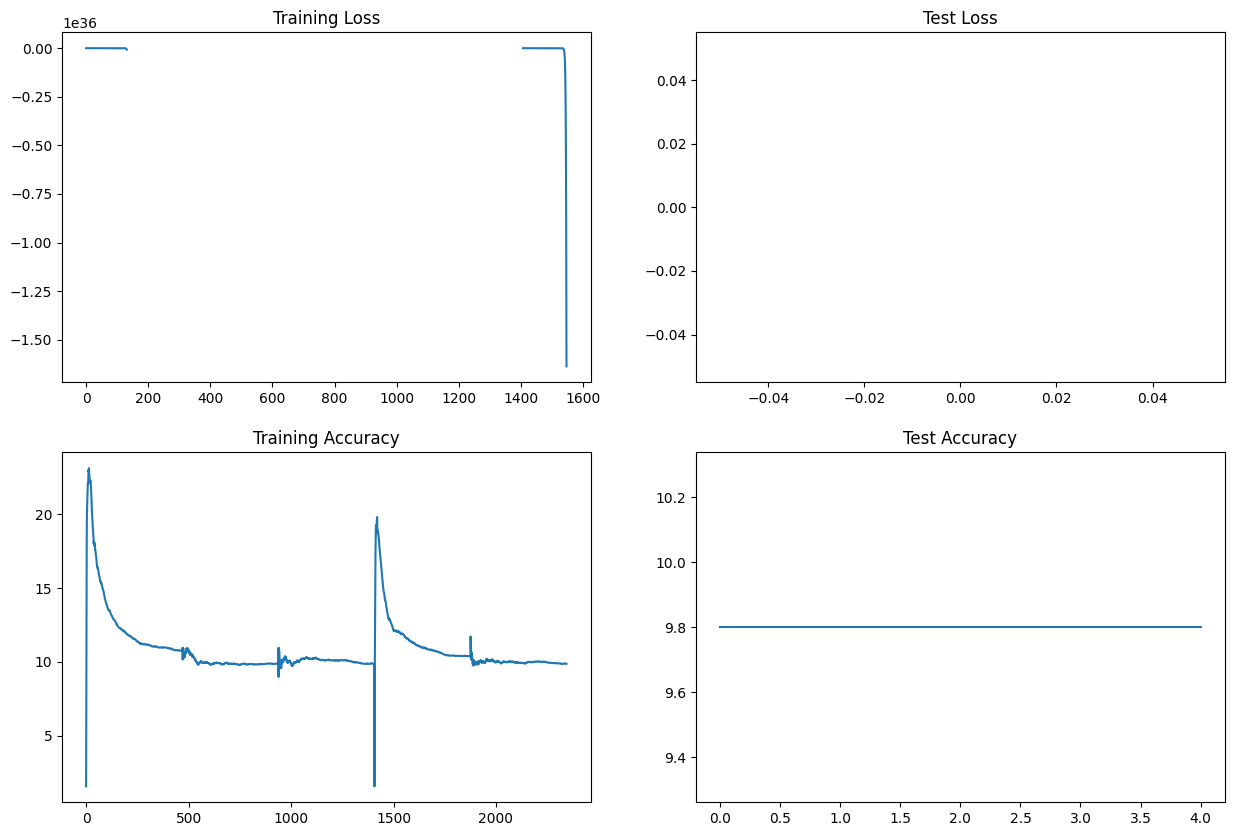

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")